In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict

# Preparation

In [7]:
MODEL_FILEDIR = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/'
METADATA_FILEPATH = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/METADATA.csv'
MODEL_NUM = 120
# MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
# OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/'


def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

In [3]:
model = torch.load('/scratch/jialin/cyber-apk-nov2023/model/id-00000001/model.pt')

In [6]:
model.keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])

# Load Metadata

In [14]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head()

,model_name,data_split,ground_truth,poisoned,poisoned_level,arch_level,nn_layers_level,nn_activation_function_level,svm_kernel_level,rf_trees_level,...,prepoison-unwatermarked-benign-support,prepoison-unwatermarked-malicious-precision,prepoison-unwatermarked-malicious-recall,prepoison-unwatermarked-malicious-f1-score,prepoison-unwatermarked-malicious-support,prepoison-watermarked-accuracy,prepoison-watermarked-malicious-precision,prepoison-watermarked-malicious-recall,prepoison-watermarked-malicious-f1-score,prepoison-watermarked-malicious-support
0,id-00000000,train,0,False,0,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,train,1,True,1,0,5,0,NaN,NaN,...,2250.0,0.996365,0.998179,0.997271,2746.0,0.000000,0.0,0.000000,0.000000,1215.0
2,id-00000002,train,1,True,1,0,4,0,NaN,NaN,...,2250.0,0.996000,0.997451,0.996725,2746.0,0.378422,1.0,0.378422,0.549065,1242.0
3,id-00000003,train,1,True,1,0,3,0,NaN,NaN,...,2250.0,0.997450,0.997087,0.997268,2746.0,1.000000,1.0,1.000000,1.000000,1265.0
4,id-00000004,train,1,True,1,0,2,0,NaN,NaN,...,2250.0,0.992764,0.999272,0.996007,2746.0,0.021721,1.0,0.021721,0.042518,1197.0


In [4]:
clean_exmp_data_dirpath = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/id-00000001/clean-example-data'
poisoned_exmp_data_dirpath = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/id-00000001/clean-example-data'#'/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/id-00000001/poisoned-example-data'

In [25]:
poisoned_data, poisoned_label = [], []
for poisoned_data_filepath in os.listdir(poisoned_exmp_data_dirpath):
    if poisoned_data_filepath.endswith('.npy'):
        p_data = np.load(os.path.join(poisoned_exmp_data_dirpath, poisoned_data_filepath))
        poisoned_data.append(p_data)
        with open(os.path.join(poisoned_exmp_data_dirpath, poisoned_data_filepath+'.json'), 'r') as label_file:
            poisoned_label.append(json.load(label_file))

In [30]:
poisoned_data = np.asarray(poisoned_data)

In [31]:
poisoned_data.max(), poisoned_data.min()

(200434000000.0, -1236895364.0)

In [6]:
layer_size_dict = {n_level:[] for n_level in range(6)}
for model_num in range(MODEL_NUM):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    nn_level = METADATA[METADATA['model_name'] == model_id]['nn_layers_level'].item()
    
    layer_size_dict[nn_level].append(os.path.getsize(model_filepath))



In [7]:
for k, v in layer_size_dict.items():
    print(k, np.mean(v))

0 57363.0
5 262235.0
4 221157.0
3 180207.0
2 139259.0
1 98311.0


# Feature Extraction

## Aggregated Weight

In [8]:
def extract_weight(model_repr : dict, layer_ind=[0, 1, -2, -1], axis=0):
    params = []
    od_keys = [k for k in model_repr.keys()]
    for ind in layer_ind:
        param = model_repr[od_keys[ind]]
        if len(param.shape) > 1:
            params += np.amax(param, axis=axis).tolist()
            params += np.mean(param, axis=axis).tolist()
            sub = np.mean(param, axis=axis) - np.median(param, axis=axis)
            params += sub.tolist()
            params += np.median(param, axis=axis).tolist()
            params += np.sum(param, axis=axis).tolist()
            params.append(np.linalg.norm(param, ord='fro')**2/np.linalg.norm(param, ord=2)**2)
        else:
            params.append(param.max().tolist())
            params.append(param.mean().tolist())
            sub = param.mean() - np.median(param)
            params.append(sub.tolist())
            params.append(np.median(param).tolist())
            params.append(param.sum().tolist())
            params.append((np.linalg.norm(param.reshape(param.shape[0], -1), ord='fro')**2/np.linalg.norm(param.reshape(param.shape[0], -1), ord=2)**2).tolist())
    return params

In [36]:
model_num = 0
model_id = num_to_model_id(model_num)
model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
model = torch.load(model_filepath)
model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})

p = extract_weight(model_repr)

In [11]:
p.shape

(1189,)

In [4]:
ind = [i for i in METADATA[METADATA['nn_layers_level'] >= 0].index]

In [42]:
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.abs(np.fft.fftshift(ft).flatten()) 

In [22]:
def _get_stats_from_weight_features(weight: np.ndarray, axis= (0,), normalized=False) -> list:
    params = []
    
    try:
        norm = np.linalg.norm(weight, ord=2)
    except:
        norm = np.linalg.norm(weight.reshape(weight.shape[0], -1), ord=2)
    
    if not normalized:
        norm = 1

    weight /= norm
    p_max = np.amax(weight, axis=axis) 
    p_mean = np.mean(weight, axis=axis)
    p_median = np.median(weight, axis=axis) 
    p_sub = p_mean - p_median
    p_sum = np.sum(weight, axis=axis)

    try:
        p_rank = [np.linalg.norm(weight, ord='fro')**2/np.linalg.norm(weight, ord=2)**2]
        for ord in [2, 'fro', np.Inf, -np.Inf, 'nuc']:
            p_rank.append(np.linalg.norm(weight, ord=ord))
    except:
        reshaped_weight = weight.reshape(weight.shape[0], -1)
        p_rank = [np.linalg.norm(reshaped_weight, ord='fro')**2/np.linalg.norm(reshaped_weight, ord=2)**2]
        for ord in [2, 'fro', np.Inf, -np.Inf, 'nuc']:
            p_rank.append(np.linalg.norm(reshaped_weight, ord=ord))
    
    if len(weight.shape) - len(axis) == 0:
        params = [p_max.tolist(), p_mean.tolist(), p_sub.tolist(), p_median.tolist(), p_sum.tolist()] + p_rank
    else:
        params = p_max.tolist() + p_mean.tolist() + p_sub.tolist() + p_median.tolist() + p_sum.tolist() + p_rank
    return params

In [5]:
def _get_multiplied_weight_features(model_repr: dict, ordered_keys: list, normalized=False, ord=2) -> np.ndarray:
    weight = None
    for ok in ordered_keys:
        if normalized:
            if ord == 'sqrt':
                norm = np.sqrt(np.linalg.norm(model_repr[ok], ord=2))
            elif ord == 'sq':
                norm = np.square(np.linalg.norm(model_repr[ok], ord=2))
            else:
                norm = np.linalg.norm(model_repr[ok], ord=ord)
            weight = model_repr[ok] / norm if weight is None else (weight @ model_repr[ok]/norm)  
        else:
            weight = model_repr[ok] if weight is None else weight @ model_repr[ok]
    return weight

In [26]:
X, y = [], []
for model_num in tqdm(range(120)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model = torch.load(model_filepath)
    model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})

    reversed_order_key = [k for k in model_repr.keys() if 'weight' in k][::-1]
    final_layer = reversed_order_key[0].split('.')[0]
    
    features = []
    for k in ['fc1.weight', f'{final_layer}.weight']:
        f = _get_stats_from_weight_features(model_repr[k], normalized=True)
        features += f
    # mat_mul_weights = _get_multiplied_weight_features(model_repr, reversed_order_key, normalized=True)
    # features += mat_mul_weights.flatten().tolist()
    # features += _get_stats_from_weight_features(mat_mul_weights, axis=(0, 1))

    X.append(features)
    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()
    y.append(poisoned)

100%|██████████| 120/120 [00:01<00:00, 74.39it/s]


## Eigen Value

In [21]:
def extract_eigen(model):
    params = []
    num_param_per_layer = []
    min_shape = 1
    for param in model.parameters():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            squared_singular_values = torch.square(singular_values)
            ssv = squared_singular_values.tolist()
            params += ssv
            num_param_per_layer.append(len(ssv))
        return np.asarray(params), np.asarray(num_param_per_layer)

In [33]:
X, y = [], []
for model_num in tqdm(range(MODEL_NUM)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model = torch.load(model_filepath)
    model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})
    reversed_order_key = [k for k in model_repr.keys() if 'weight' in k][::-1]
    final_layer = reversed_order_key[0].split('.')[0]

    features = []
    for k in ['fc1.weight', f'{final_layer}.weight']:
        fc1_weight = model_repr['fc1.weight'].T.reshape(135, 10, 10)
        mat = model_repr[k]
        norm = np.linalg.norm(mat)
        _, s, _ = np.linalg.svd(mat.reshape(mat.shape[0], -1)/norm)
        features.extend(s.flatten().tolist()[:100])

    X.append(features)
    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()
    y.append(poisoned)
X = np.asarray(X)

100%|██████████| 120/120 [00:01<00:00, 82.16it/s]


In [42]:
eigen_dict.shape

(120, 1350)

In [105]:
X, y = [], []
for model_num in range(MODEL_NUM):
    model_id = num_to_model_id(model_num)
    
    # x_weight = weight_dict[model_id][:507].tolist() + weight_dict[model_id][-17:].tolist()
    x_weight = weight_dict[model_id].tolist()
    x_eigen = eigen_dict[model_id][:100].tolist() + eigen_dict[model_id][-2:].tolist()
    X.append(x_weight + x_eigen)
    
    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()
    y.append(poisoned)
X = np.asarray(X)

# Visualization

In [18]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2):
    all_cross_entropy, all_accuracy = [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        if np.unique(y_train).shape[0] == 1 or np.unique(y_test).shape[0] == 1:
            continue
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test)))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [20]:
clf = GradientBoostingClassifier(learning_rate=.02, n_estimators=875, max_depth= 4, max_features= 15, min_samples_leaf= 2, min_samples_split= 35)
for k, v in X.items():
    cen, acc = bootstrap_performance(v, y, clf, n=100, test_size=.2)
    print(f'ord {k}', np.mean(cen), np.mean(acc))

ord 2 0.26713787293506647 0.8929166666666666
ord sqrt 0.2741798298756312 0.8858333333333333
ord sq 0.40496011792993913 0.8137500000000002
ord 1 0.4836750759609604 0.7770833333333332


In [5]:
X, y = np.load('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight_curr_best/X.npy'), np.load('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight_curr_best/y.npy')

In [44]:
# clf = GradientBoostingClassifier(learning_rate=.04, n_estimators=925, max_depth= 4, max_features= 5, min_samples_leaf= 6, min_samples_split= 24)
clf = GradientBoostingClassifier(learning_rate=.02, n_estimators=875, max_depth= 4, min_samples_leaf= 2, min_samples_split= 35)  #, max_features= 15
cen, acc = bootstrap_performance(X, y, clf, n=50, test_size=.2) 
print(np.mean(cen), np.mean(acc))

1.2349624655578022 0.5728


In [46]:
import joblib
joblib.dump(clf.fit(X, y), './clf.joblib')

['./clf.joblib']

In [38]:
model = torch.load('/scratch/jialin/cyber-apk-nov2023/model/id-00000001/model.pt', map_location=torch.device('cpu'))
model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.items()})

reversed_order_key = [k for k in model_repr.keys() if 'weight' in k][::-1]
final_layer = reversed_order_key[0].split('.')[0]

features = []
for k in ['fc1.weight', f'{final_layer}.weight']:
    mat = model_repr[k]
    norm = np.linalg.norm(mat)
    _, s, _ = np.linalg.svd(mat.reshape(mat.shape[0], -1)/norm)
    features.extend(s.flatten().tolist()[:100])

In [43]:
X = np.concatenate([X, np.expand_dims(np.asarray(features), axis=0)], axis=0)
y.append(True)

In [36]:
clf.fit(X, y).predict_proba([features])

array([[0.99559411, 0.00440589]])

681, 692, 1198, 1209, 1479

In [13]:
sum(np.sort(clf.feature_importances_)[::-1][:500])

0.9948405975464009

In [14]:
ind = np.sort(np.argsort(clf.feature_importances_)[::-1][:500])

In [15]:
X_ind = X[:, ind]

In [30]:
np.save('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/ind_with_last_layer.npy', ind)

In [9]:
X.shape

(120, 952)

In [34]:
np.argsort(clf.feature_importances_)[::-1][:100]

array([896, 761, 501, 700, 925, 946, 763, 704, 741, 870, 713, 898, 104,
       122, 145, 817,  46, 860, 873, 689, 577, 550, 811, 336, 927,  56,
       823, 772, 934, 245, 792, 876, 172, 806, 958, 390,  40, 366, 272,
         8,   4, 754, 523, 152, 848, 636, 505,  16, 837, 137, 835, 951,
       128, 240, 711, 915, 106, 725, 223, 650,  69, 398, 935, 113, 133,
       800, 639, 413, 910, 642,  80, 161, 486, 790, 929, 171, 760, 628,
       599,  60, 638, 855, 816, 647, 302, 684, 611, 785, 877, 881,  42,
       673,  48, 840, 617, 318, 952, 756,   7,  59])

In [39]:
np.argsort(cen)

array([44, 34, 38, 24, 25, 14, 55, 40,  4, 23, 18, 82, 67, 73, 10, 51, 75,
       66, 64, 32,  5, 89, 65, 26, 41, 91, 95, 63, 16,  2, 54, 36, 35, 56,
       93, 27, 49, 77, 52, 31,  7,  0,  1,  3, 43, 48, 47, 50, 80, 84, 99,
       11, 42,  6, 78, 37, 39, 53, 62, 71, 94, 60, 28, 45, 22, 33, 46, 17,
       20, 61, 70, 59, 98, 83, 81, 88, 97, 96, 74, 90, 57, 58, 15, 87, 12,
       69, 19, 30, 76,  8, 86, 79,  9, 68, 13, 72, 29, 21, 92, 85])

In [40]:
np.argsort(acc)[::-1]

array([25, 67, 34, 44, 24, 14, 18, 38, 63, 64, 32, 75, 26, 23, 51, 82, 55,
       10, 89, 91,  5,  4, 16, 66, 41, 40, 54, 97, 53,  1,  2, 65, 35,  3,
       36, 50, 71, 73, 27,  6,  7, 49, 45, 31, 42, 39, 37, 47, 20, 11, 46,
       99, 48, 62, 96, 95, 88, 84, 83, 77, 74, 80,  0, 52, 56, 57, 59, 78,
       94, 93, 43, 13, 17, 22, 61, 58, 76, 69, 33, 30, 60, 87, 98, 79, 28,
       81, 12, 15, 86, 68,  9,  8, 19, 90, 72, 70, 29, 21, 85, 92])

In [44]:
cen[44]

0.10636620460274804

features - cen, acc
stats from first layer normed weight and bias, 270 mat-mul normed weight - 0.336, 0.869
stats from first layer raw weight and bias, 270 mat-mul normed weight - 0.401, 0.821
stats from first layer normed weight and bias, 270 mat-mul normed weight, fft from mat-mul normed weight - 0.241, 0.889
stats from first layer normed weight and bias, 270 mat-mul normed weight, previous 38 eigen - 0.276, .881

visualize the matrix;
stats per layer, choose the front few eigen values from each layer - Net 3 and above, look at 1st and 2nd layer
Net 1 & Net 2  (or padding the addtional feature points to 0)

In [4]:
FOLDER = '/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight_curr_best'
X, y = np.load(os.path.join(FOLDER, 'X.npy')), np.load(os.path.join(FOLDER, 'y.npy'))

In [12]:
IND_DIR = '/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/limit_feature/'
for ind_fp in os.listdir(IND_DIR):
    if ind_fp.endswith('.npy'):
        ind_file = np.load(os.path.join(IND_DIR, ind_fp)) 
        print(ind_fp, ind_file.shape)

ind_fft.npy (455,)
ind_eigen.npy (560,)
ind_rw.npy (450,)


In [5]:
X_extract = X[:, 682+211:682+250]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = torch.load('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/for_container/learned_parameters/best_rnn_model.pt')
model.eval()

# test_dataset = TensorDataset(torch.Tensor(X_extract[[0]]).float().reshape(-1,1,39), torch.Tensor(y[[0]]).float())
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)
features = torch.Tensor(X_extract[[3]]).float().unsqueeze(0).permute(2, 0, 1)
with torch.no_grad():
    output = model(features)
    output = torch.sigmoid(output.reshape(-1))
output

In [18]:
features.shape

torch.Size([39, 1, 1])

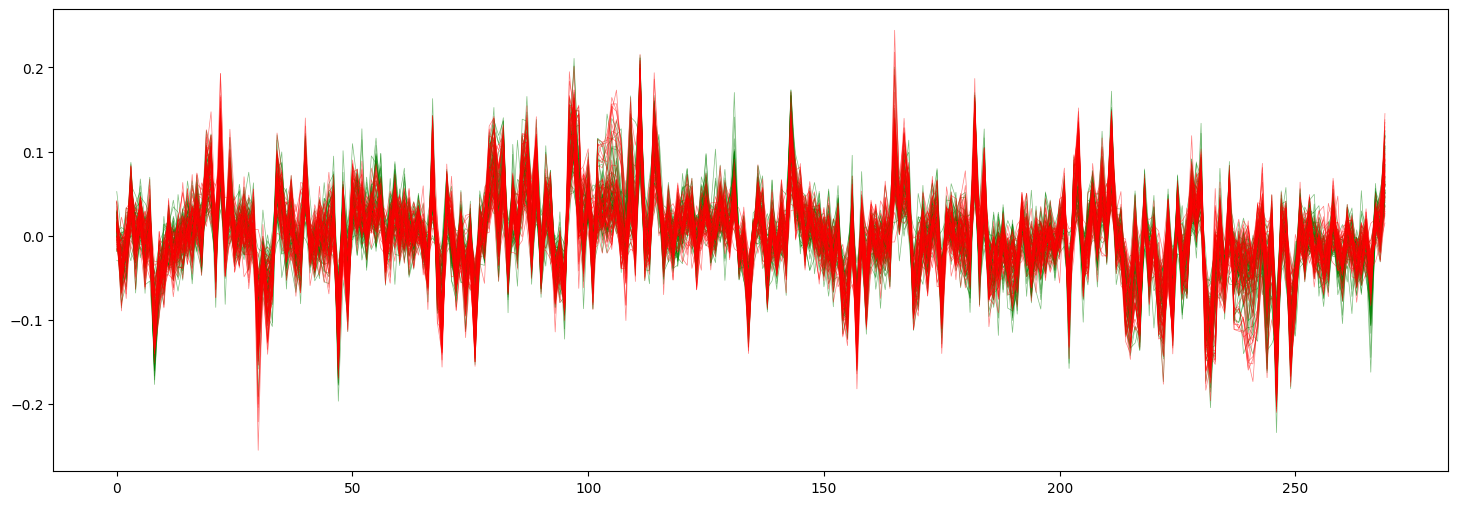

In [47]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(trojan_X.T, c='green', linewidth=.5, alpha=.5);
ax.plot(clean_X.T, c='red', linewidth=.5, alpha=.5);

# Tune/Train Models

In [5]:
OUTPUT_FILEDIR = '/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source'

with fft

In [6]:
X_ind, y = np.load(os.path.join(OUTPUT_FILEDIR, 'X.npy')), np.load(os.path.join(OUTPUT_FILEDIR, 'y.npy'))


In [14]:
import joblib
clf = joblib.load(os.path.join(OUTPUT_FILEDIR, 'norm_first_layer_norm_raw_weight_norm_fft', 'small_net_detector.joblib'))

In [22]:
imp_fe = np.argsort(clf.feature_importances_)[::-1][:455]
np.sum(clf.feature_importances_[imp_fe])
np.save(os.path.join(OUTPUT_FILEDIR, 'ind_fft.npy'), np.sort(imp_fe))

In [9]:
clf = GradientBoostingClassifier(learning_rate=.04, n_estimators=925, max_depth= 4, max_features= 5, min_samples_leaf= 6, min_samples_split= 24)
# param={'max_depth': range(3, 5), 'min_samples_leaf': range(2, 103, 10), 'min_samples_split': range(4, 205, 20), 'max_features': range(20, 501, 20)}
# param = {'learning_rate':np.arange(.005, .0251, .001), 'n_estimators':range(200, 1201, 25)}
param = {'learning_rate':np.arange(.01, .051, .001), 'n_estimators':range(500, 1501, 25)}
# param = {'learning_rate':[.01, .005, .015, .03, .0075], 'n_estimators':[650, 1300, 450, 225, 900]}
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X_ind, y);

In [10]:
gsearch_result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss','rank_test_accuracy'])
gsearch_result.to_csv(os.path.join(OUTPUT_FILEDIR, 'gsearch_result_with_last_layer.csv'))

In [43]:
clf = GradientBoostingClassifier(learning_rate=.019, n_estimators=1125, max_depth= 4, max_features= 10, min_samples_leaf= 2, min_samples_split= 16)
cen, acc = bootstrap_performance(X_ind, y, clf, n=100, test_size=.2)
print(np.mean(cen), np.mean(acc))

0.18749927923984633 0.9225


In [12]:
np.argsort(cen)

array([24, 52, 40, 13, 97, 32, 78, 14, 44, 21, 56, 16, 54, 79, 42, 31, 25,
       80, 71, 50,  3, 77, 81, 23, 73, 51, 70, 38, 33, 17, 85,  0, 92, 18,
       63, 91, 64, 26, 96, 57, 37, 43, 35, 61, 68, 89, 60, 55,  1, 34, 72,
        2, 67, 74, 47, 22, 28, 48, 10, 62, 75, 82, 45,  9, 36, 86, 12, 53,
       19, 46,  6, 69, 59, 83, 39, 65,  4, 94, 84,  5, 66, 95, 99, 27, 41,
       30, 88, 98, 15, 20, 87, 93, 90, 76, 58, 49,  7, 11, 29,  8])

In [13]:
cen[24], cen[52], cen[40], cen[13], cen[97]

(0.022045971938773085,
 0.0384489115553582,
 0.03916551452215918,
 0.042201285178241406,
 0.042492805037043946)

In [14]:
np.argsort(acc)[::-1]

array([16, 24, 40, 79, 78, 32, 13, 52, 25, 14, 56, 97, 44, 43, 54, 55, 50,
       61, 33, 42, 37, 68, 31, 26, 23, 21, 18, 17, 64,  0, 81, 70, 71, 77,
       72, 80,  3, 85, 10, 38, 84, 36, 35, 34, 82, 86, 28,  2, 91, 92, 22,
        1, 94, 96, 12, 57, 67, 66, 51, 63, 62, 75, 74, 73, 60,  9, 45, 89,
       95, 19, 65, 59, 15, 88,  5, 30, 53,  6, 48, 11, 83, 47, 69,  4, 99,
       27, 29, 39, 41, 46, 98, 76, 87, 90, 93, 49,  7, 58, 20,  8])

In [15]:
acc[24]

1.0

In [16]:
import joblib
# clf = GradientBoostingClassifier(learning_rate=.018, n_estimators=560, min_samples_leaf=44, max_depth=3, max_features=656, min_samples_split=56).fit(weight_dict_X, weight_dict_y)
# clf = GradientBoostingClassifier(learning_rate=.007, n_estimators=750, max_depth= 4, max_features= 360, min_samples_leaf= 2, min_samples_split= 22).fit(weight_dict_X, weight_dict_y)
# clf = GradientBoostingClassifier(learning_rate=.013, n_estimators=750, max_depth= 4, max_features= 750, min_samples_leaf= 16, min_samples_split= 36).fit(weight_dict_X, weight_dict_y)
# clf = GradientBoostingClassifier(learning_rate=.015, n_estimators=875, max_depth= 3, max_features= 30, min_samples_leaf= 16, min_samples_split= 30).fit(X, y)
# clf = GradientBoostingClassifier(learning_rate=.016, n_estimators=525, max_depth= 4, max_features= 15, min_samples_leaf= 4, min_samples_split= 20).fit(fe_X, fe_y)
# clf = GradientBoostingClassifier(learning_rate=.02, n_estimators=675, max_depth= 4, max_features= 30, min_samples_leaf= 2, min_samples_split= 20, random_state=40).fit(fe_X, fe_y)
# clf = GradientBoostingClassifier(learning_rate=.02, n_estimators=875, max_depth= 4, max_features= 15, min_samples_leaf= 2, min_samples_split= 35, random_state=34).fit(fe_X, fe_y)
# clf = GradientBoostingClassifier(learning_rate=.019, n_estimators=1050, max_depth= 4, max_features= 4, min_samples_leaf= 2, min_samples_split= 40, random_state=44).fit(X[:, np.sort(imp_fe)], y)
# clf = GradientBoostingClassifier(learning_rate=.025, n_estimators=725, max_depth= 4, max_features= 40, min_samples_leaf= 2, min_samples_split= 32, random_state=21).fit(X, y)
# clf = GradientBoostingClassifier(learning_rate=.019, n_estimators=1125, max_depth= 4, max_features= 10, min_samples_leaf= 2, min_samples_split= 16, random_state=16).fit(X_ind, y)
clf = GradientBoostingClassifier(learning_rate=.04, n_estimators=925, max_depth= 4, max_features= 5, min_samples_leaf= 6, min_samples_split= 24, random_state=24).fit(X_ind, y)
joblib.dump(clf, os.path.join(OUTPUT_FILEDIR, 'detector_final_layer2.joblib'))

['/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/detector_final_layer2.joblib']

In [118]:
np.save(os.path.join(OUTPUT_FILEDIR, 'X.npy'), weight_dict_X)
np.save(os.path.join(OUTPUT_FILEDIR, 'y.npy'), weight_dict_y)

In [30]:
X, y = np.load(os.path.join('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight', 'fe_X.npy')), np.load(os.path.join('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight', 'fe_y.npy'))
X.shape, y.shape

((120, 952), (120,))

In [121]:
clf = GradientBoostingClassifier(learning_rate=.018, n_estimators=560, min_samples_leaf=44, max_depth=3, max_features=656, min_samples_split=56)
# clf = GradientBoostingClassifier(learning_rate=.01, n_estimators=500)
cen, acc = bootstrap_performance(X, y, clf, n=50, test_size=.2)
print(np.mean(cen), np.mean(acc))

0.6261368925796619 0.6691666666666667
